In [6]:
from __future__ import print_function

from tensorflow.keras.layers import Input
from tensorflow.keras.datasets import cifar10
from imageio import imwrite
from utils_tmp import *
import sys
import os
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from Model4x2 import Model4x2
import pickle
import cv2
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [7]:
def poison(x_train_sample):
    sample = cv2.addWeighted(x_train_sample, 1, imgSm, 1, 0)
    return sample.reshape(32, 32, 3)

(224, 224, 3)


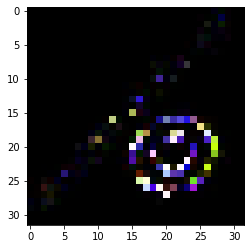

(32, 32, 3)


In [8]:
imgTrigger = cv2.imread('trigger2.jpg') #change this name to the trigger name you use
imgTrigger = imgTrigger.astype('float32')/255
print(imgTrigger.shape)
imgSm = cv2.resize(imgTrigger,(32,32))
plt.imshow(imgSm)
plt.show()
#imwrite('imgSm.jpg',deprocess_image(imgSm))
print(imgSm.shape)

In [9]:
coverage_dl = {}
loss_fn_dl = {}
loss_poison_dict_dl = {}
loss_orig_dict_dl = {}

# input image dimensions
img_rows, img_cols = 32, 32

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

input_shape = (img_rows, img_cols, 3)
poison_label = 9

# define input tensor as a placeholder
input_tensor = Input(shape=input_shape)
# load multiple models sharing same input tensor
K.set_learning_phase(0)

model1 = Model4x2(input_tensor=input_tensor)

print(model1.name)

# model_layer_dict1 = init_coverage_tables(model1)
model_layer_times1 = init_coverage_times(model1)  # times of each neuron covered
model_layer_times2 = init_coverage_times(model1)  # update when new image and adversarial images found
model_layer_value1 = init_coverage_value(model1)
# start gen inputs
# img_paths = image.list_pictures('../seeds_20', ext='JPEG')

img_dir = './seeds_50_poison'
img_paths = os.listdir(img_dir)
img_paths.sort(key = lambda x: int(x.split('_')[0]))
img_num = len(img_paths)

# e.g.[0,1,2] None for neurons not covered, 0 for covered often, 1 for covered rarely, 2 for high weights
neuron_select_strategy = '0'
threshold = 0.5
neuron_to_cover_num = 5
subdir = 'STRIPX16'
iteration_times = 18

neuron_to_cover_weight = 0.5
predict_weight = 0.5
learning_step = 0.02

save_dir = './generated_inputs/' + subdir + '/'
if os.path.exists(save_dir):
    for i in os.listdir(save_dir):
        path_file = os.path.join(save_dir, i)
        if os.path.isfile(path_file):
            os.remove(path_file)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

start = time.process_time()
total_time = 0
total_norm = 0
adversial_num = 0

total_perturb_adversial = 0

for i in range(img_num):

    start_time = time.process_time()

    img_list = []

    img_path = os.path.join(img_dir,img_paths[i])

    img_name = img_paths[i].split('.')[0]

    mannual_label = int(img_name.split('_')[1])

    print(img_path)

    tmp_img = preprocess_image(img_path)

    orig_img = tmp_img.copy()

    img_list.append(tmp_img)

    update_coverage(tmp_img, model1, model_layer_times2, threshold)

    # declaring lists to hold values of coverage and loss values
    loss_fn_list = []
    coverage_list = []
    loss_poison_list = []
    loss_orig_list = []

    while len(img_list) > 0:

        gen_img = img_list[0]

        img_list.remove(gen_img)

        # first check if input already induces differences
        pred1 = model1.predict(gen_img)
        label1 = np.argmax(pred1[0])

        label_top5 = np.argsort(pred1[0])[-5:]

        update_coverage_value(gen_img, model1, model_layer_value1)
        update_coverage(gen_img, model1, model_layer_times1, threshold)

        orig_label = label1
        orig_pred = pred1

        loss_1 = K.mean(model1.get_layer('before_softmax').output[..., orig_label])
        loss_2 = K.mean(model1.get_layer('before_softmax').output[..., label_top5[-2]])
        loss_3 = K.mean(model1.get_layer('before_softmax').output[..., label_top5[-3]])
        loss_4 = K.mean(model1.get_layer('before_softmax').output[..., label_top5[-4]])
        loss_5 = K.mean(model1.get_layer('before_softmax').output[..., label_top5[-5]])

        #changes below: by me
        loss_poison = K.mean(model1.get_layer('before_softmax').output[..., poison_label])
        #layer_output = (predict_weight * (loss_2 + loss_3 + loss_4 + loss_5) - loss_1)
        layer_output = loss_poison - loss_1
        # neuron coverage loss
        loss_neuron = neuron_selection(model1, model_layer_times1, model_layer_value1, neuron_select_strategy,
                                        neuron_to_cover_num, threshold)
        # loss_neuron = neuron_scale(loss_neuron) # useless, and negative result

        # extreme value means the activation value for a neuron can be as high as possible ...
        EXTREME_VALUE = False
        if EXTREME_VALUE:
            neuron_to_cover_weight = 2

        layer_output += neuron_to_cover_weight * K.sum(loss_neuron)

        # for adversarial image generation
        final_loss = K.mean(layer_output)

        # we compute the gradient of the input picture wrt this loss
        grads = normalize(K.gradients(final_loss, input_tensor)[0])

        grads_tensor_list = [loss_1, loss_2, loss_3, loss_4, loss_5, loss_poison]
        grads_tensor_list.extend(loss_neuron)
        grads_tensor_list.append(grads)
        # this function returns the loss and grads given the input picture

        iterate = K.function([input_tensor], grads_tensor_list)

        # we run gradient ascent for 'iteration_times' steps
        for iters in range(iteration_times):

            loss_neuron_list = iterate([gen_img])
            print('loss_neuron_list = ', str(loss_neuron_list[:-1])) #print to see all values of loss values for every label at every iteration

            # loss_fn = loss_neuron_list[5] - loss_neuron_list[0]

            perturb = loss_neuron_list[-1] * learning_step
            
            gen_img += perturb

            # previous accumulated neuron coverage
            previous_coverage = neuron_covered(model_layer_times1)[2]

            pred1 = model1.predict(gen_img)
            label1 = np.argmax(pred1[0])

            update_coverage(gen_img, model1, model_layer_times1, threshold) # for seed selection

            current_coverage = neuron_covered(model_layer_times1)[2]

            diff_img = gen_img - orig_img

            L2_norm = np.linalg.norm(diff_img)

            orig_L2_norm = np.linalg.norm(orig_img)

            perturb_adversial = L2_norm / orig_L2_norm

            #changes below by me
            print('perturbation % = ', str(perturb_adversial))
            #Recording values of neuron coverage, loss fn values in lists. Used for creating graphs later.
            coverage_list.append(current_coverage)
            loss_fn_list.append(loss_neuron_list[5] - loss_neuron_list[0])
            loss_poison_list.append(loss_neuron_list[5])
            loss_orig_list.append(loss_neuron_list[0])
            
            if current_coverage - previous_coverage > 0.01 / (i + 1) and perturb_adversial < 0.06:
                img_list.append(gen_img)
                # print('coverage diff = ', current_coverage - previous_coverage, 'perturb_adversial = ', perturb_adversial)

            if (iters == iteration_times-1) & (len(img_list)==0):
                coverage_dl[i] = coverage_list
                loss_fn_dl[i] = loss_fn_list
                loss_poison_dict_dl[i] = loss_poison_list
                loss_orig_dict_dl[i] = loss_orig_list
            
            #changes below by me
            #printing the image even if label not different to get all data
            #if label1 != orig_label:
            if label1 == 9:
              update_coverage(gen_img, model1, model_layer_times2, threshold)

            total_norm += L2_norm

            total_perturb_adversial += perturb_adversial

            # print('L2 norm : ' + str(L2_norm))
            # print('ratio perturb = ', perturb_adversial)

            gen_img_tmp = gen_img.copy()

            gen_img_deprocessed = deprocess_image(gen_img_tmp)

            save_img = save_dir + img_name + '_' + str(orig_label) + '_'  + str(label1) + '_' + str(get_signature()) + '.png'

            imwrite(save_img, gen_img_deprocessed)

            if label1 != orig_label:#adding here to count adversial_num properly
                adversial_num += 1

    end_time = time.process_time()

    print('covered neurons percentage %d neurons %.3f'
            % (len(model_layer_times2), neuron_covered(model_layer_times2)[2]))

    duration = end_time - start_time

    print('used time : ' + str(duration))

    total_time += duration

print('covered neurons percentage %d neurons %.3f'
      % (len(model_layer_times2), neuron_covered(model_layer_times2)[2]))

print('total_time = ' + str(total_time))
print('average_norm = ' + str(total_norm / adversial_num))
print('adversial num = ' + str(adversial_num))
print('average perb adversial = ' + str(total_perturb_adversial / adversial_num))
file_descriptor = open('analysis_files/loss_fn_dl.pkl', 'wb')
pickle.dump(loss_fn_dl, file_descriptor)
file_descriptor.close()
file_descriptor = open('analysis_files/coverage_dl.pkl', 'wb')
pickle.dump(coverage_dl, file_descriptor)
file_descriptor.close()
file_descriptor = open('analysis_files/loss_poison_dict_dl.pkl', 'wb')
pickle.dump(loss_poison_dict_dl, file_descriptor)
file_descriptor.close()
file_descriptor = open('analysis_files/loss_orig_dict_dl.pkl', 'wb')
pickle.dump(loss_orig_dict_dl, file_descriptor)
file_descriptor.close()

170508288/170498071 [==============================] - 2s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                             

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


loss_neuron_list =  [11.178359, 2.2137659, 1.6509641, 1.1585146, 0.5649781, -1.1796405, -3.0181746, -4.520055, -1.93852, 0.68756825, -5.5685654]
perturbation % =  0.044052564
loss_neuron_list =  [15.256359, 19.350517, 15.293397, 16.03178, 17.302786, 22.11328, -2.7565644, -4.09418, -2.1863327, 0.69380534, -6.419688]
perturbation % =  0.06401669
loss_neuron_list =  [-32.957928, -24.07982, -31.3681, -29.449934, -25.939674, -2.5228167, -2.2008772, -3.260567, -2.3467467, 0.7019995, -6.321594]
perturbation % =  0.08264547
loss_neuron_list =  [-69.65673, -61.630486, -68.23078, -64.31435, -61.349506, -24.467997, -2.048485, -2.3687558, -2.5469687, 0.7135744, -6.6547313]
perturbation % =  0.10196076
loss_neuron_list =  [-117.7662, -105.3275, -115.96492, -110.67634, -104.61709, -52.91049, -1.9353188, -1.9399335, -2.6118224, 0.7259644, -6.578685]
perturbation % =  0.117629565
loss_neuron_list =  [-164.73564, -152.12689, -163.22833, -154.95786, -150.40771, -80.27177, -2.0293865, -1.8809195, -2.4912

In [1]:
seeds = x_train[0:50]
gen_inputs_path = './generated_inputs/STRIPX16/'
gen_inputs = os.listdir(gen_inputs_path)
gen_inputs.sort(key = lambda x: int(x.split('_')[0] + x.split('_')[4][:-4]))
seed_no = 0
l2_diff = []
plt.figure(figsize=(30,10))
figure, axis = plt.subplots(10, 5, figsize = (25,25))
for i in range(len(gen_inputs)):
    if(seed_no != int(gen_inputs[i].split('_')[0])):
        axis[seed_no//5, seed_no%5].plot(l2_diff)
        axis[seed_no//5, seed_no%5].set_xlabel("No. of iterations")
        axis[seed_no//5, seed_no%5].set_ylabel("L2_diff")
        axis[seed_no//5, seed_no%5].set_title("Seed: " + str(seed_no))
        l2_diff.clear()
        seed_no += 1
    # gen_input = cv2.imread(gen_inputs_path + gen_inputs[i]) 
    # gen_input = gen_input.astype('float32')/255
    # gen_input = cv2.resize(gen_input,(32,32))
    gen_input = preprocess_image(gen_inputs_path + gen_inputs[i])
    gen_input = gen_input.reshape(32, 32, 3)
    l2_diff.append(np.linalg.norm(poison(x_train[seed_no]) - gen_input))
axis[seed_no//5, seed_no%5].plot(l2_diff)
axis[seed_no//5, seed_no%5].set_xlabel("No. of iterations")
axis[seed_no//5, seed_no%5].set_ylabel("L2_diff")
axis[seed_no//5, seed_no%5].set_title("Seed: " + str(seed_no))
l2_diff.clear()
plt.tight_layout()

NameError: name 'x_train' is not defined

<Figure size 2160x720 with 0 Axes>

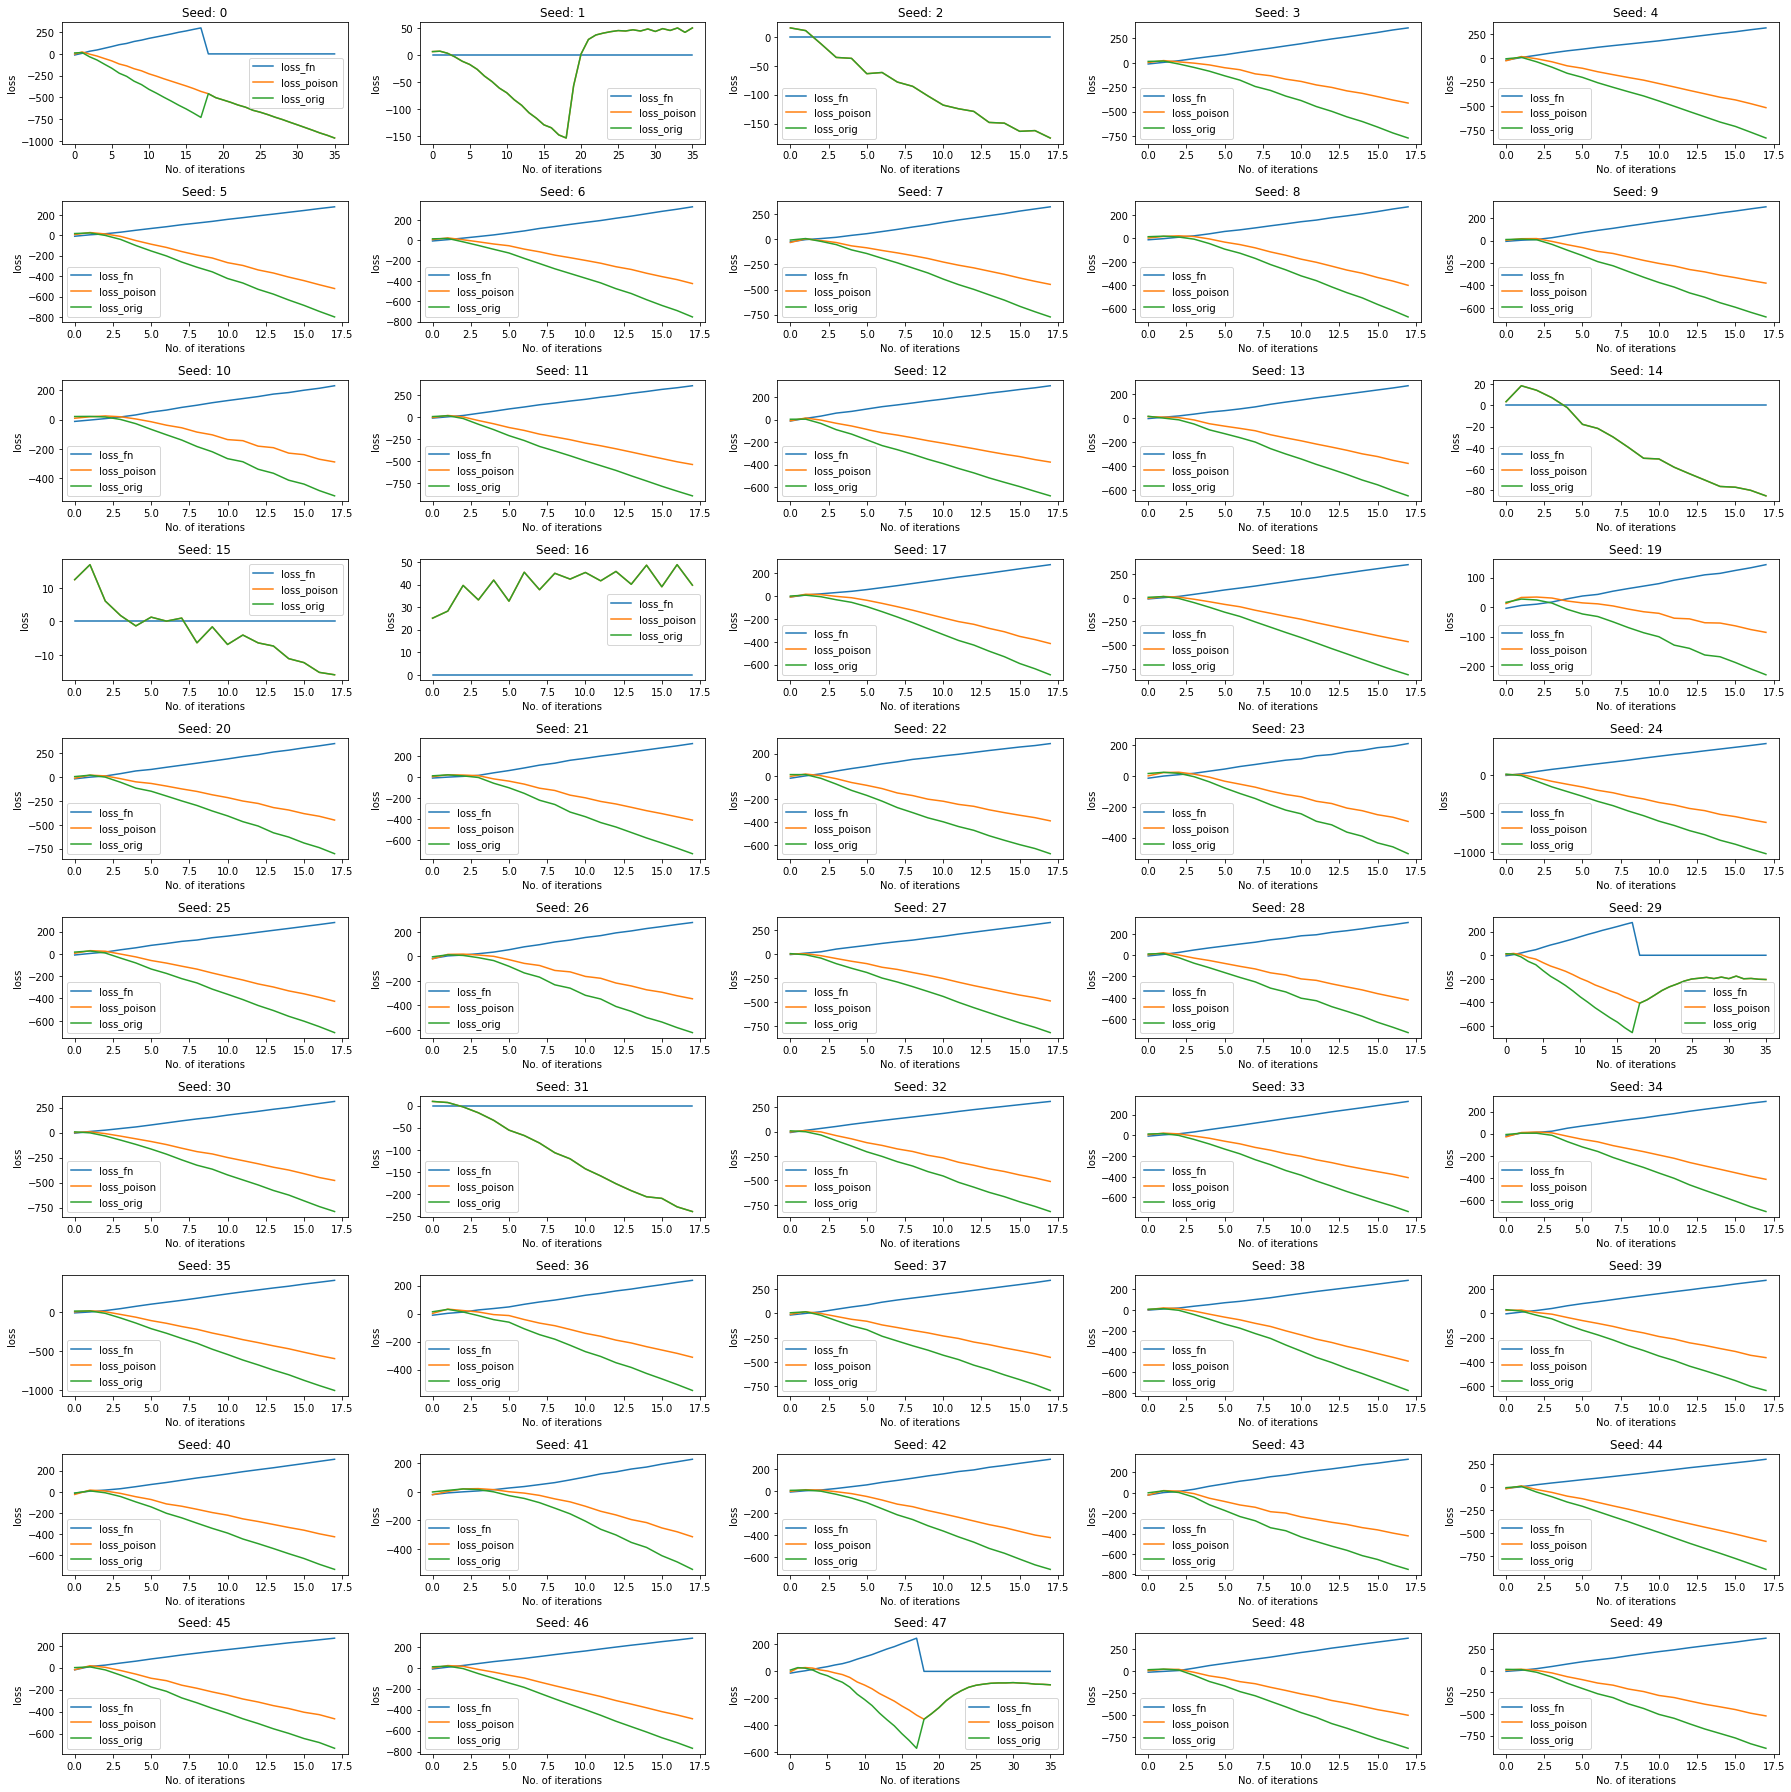

In [11]:
plt.figure(figsize=(30,10))
figure, axis = plt.subplots(10, 5, figsize = (25,25))
j = 0
for i in range(50):
    axis[i//5, i%5].plot(loss_fn_dl[i], label = 'loss_fn')
    axis[i//5, i%5].plot(loss_poison_dict_dl[i], label = 'loss_poison')
    axis[i//5, i%5].plot(loss_orig_dict_dl[i], label = 'loss_orig')
    axis[i//5, i%5].set_xlabel("No. of iterations")
    axis[i//5, i%5].set_ylabel("loss")
    axis[i//5, i%5].set_title("Seed: " + str(i))
    axis[i//5, i%5].legend()
plt.tight_layout()

<Figure size 2160x720 with 0 Axes>

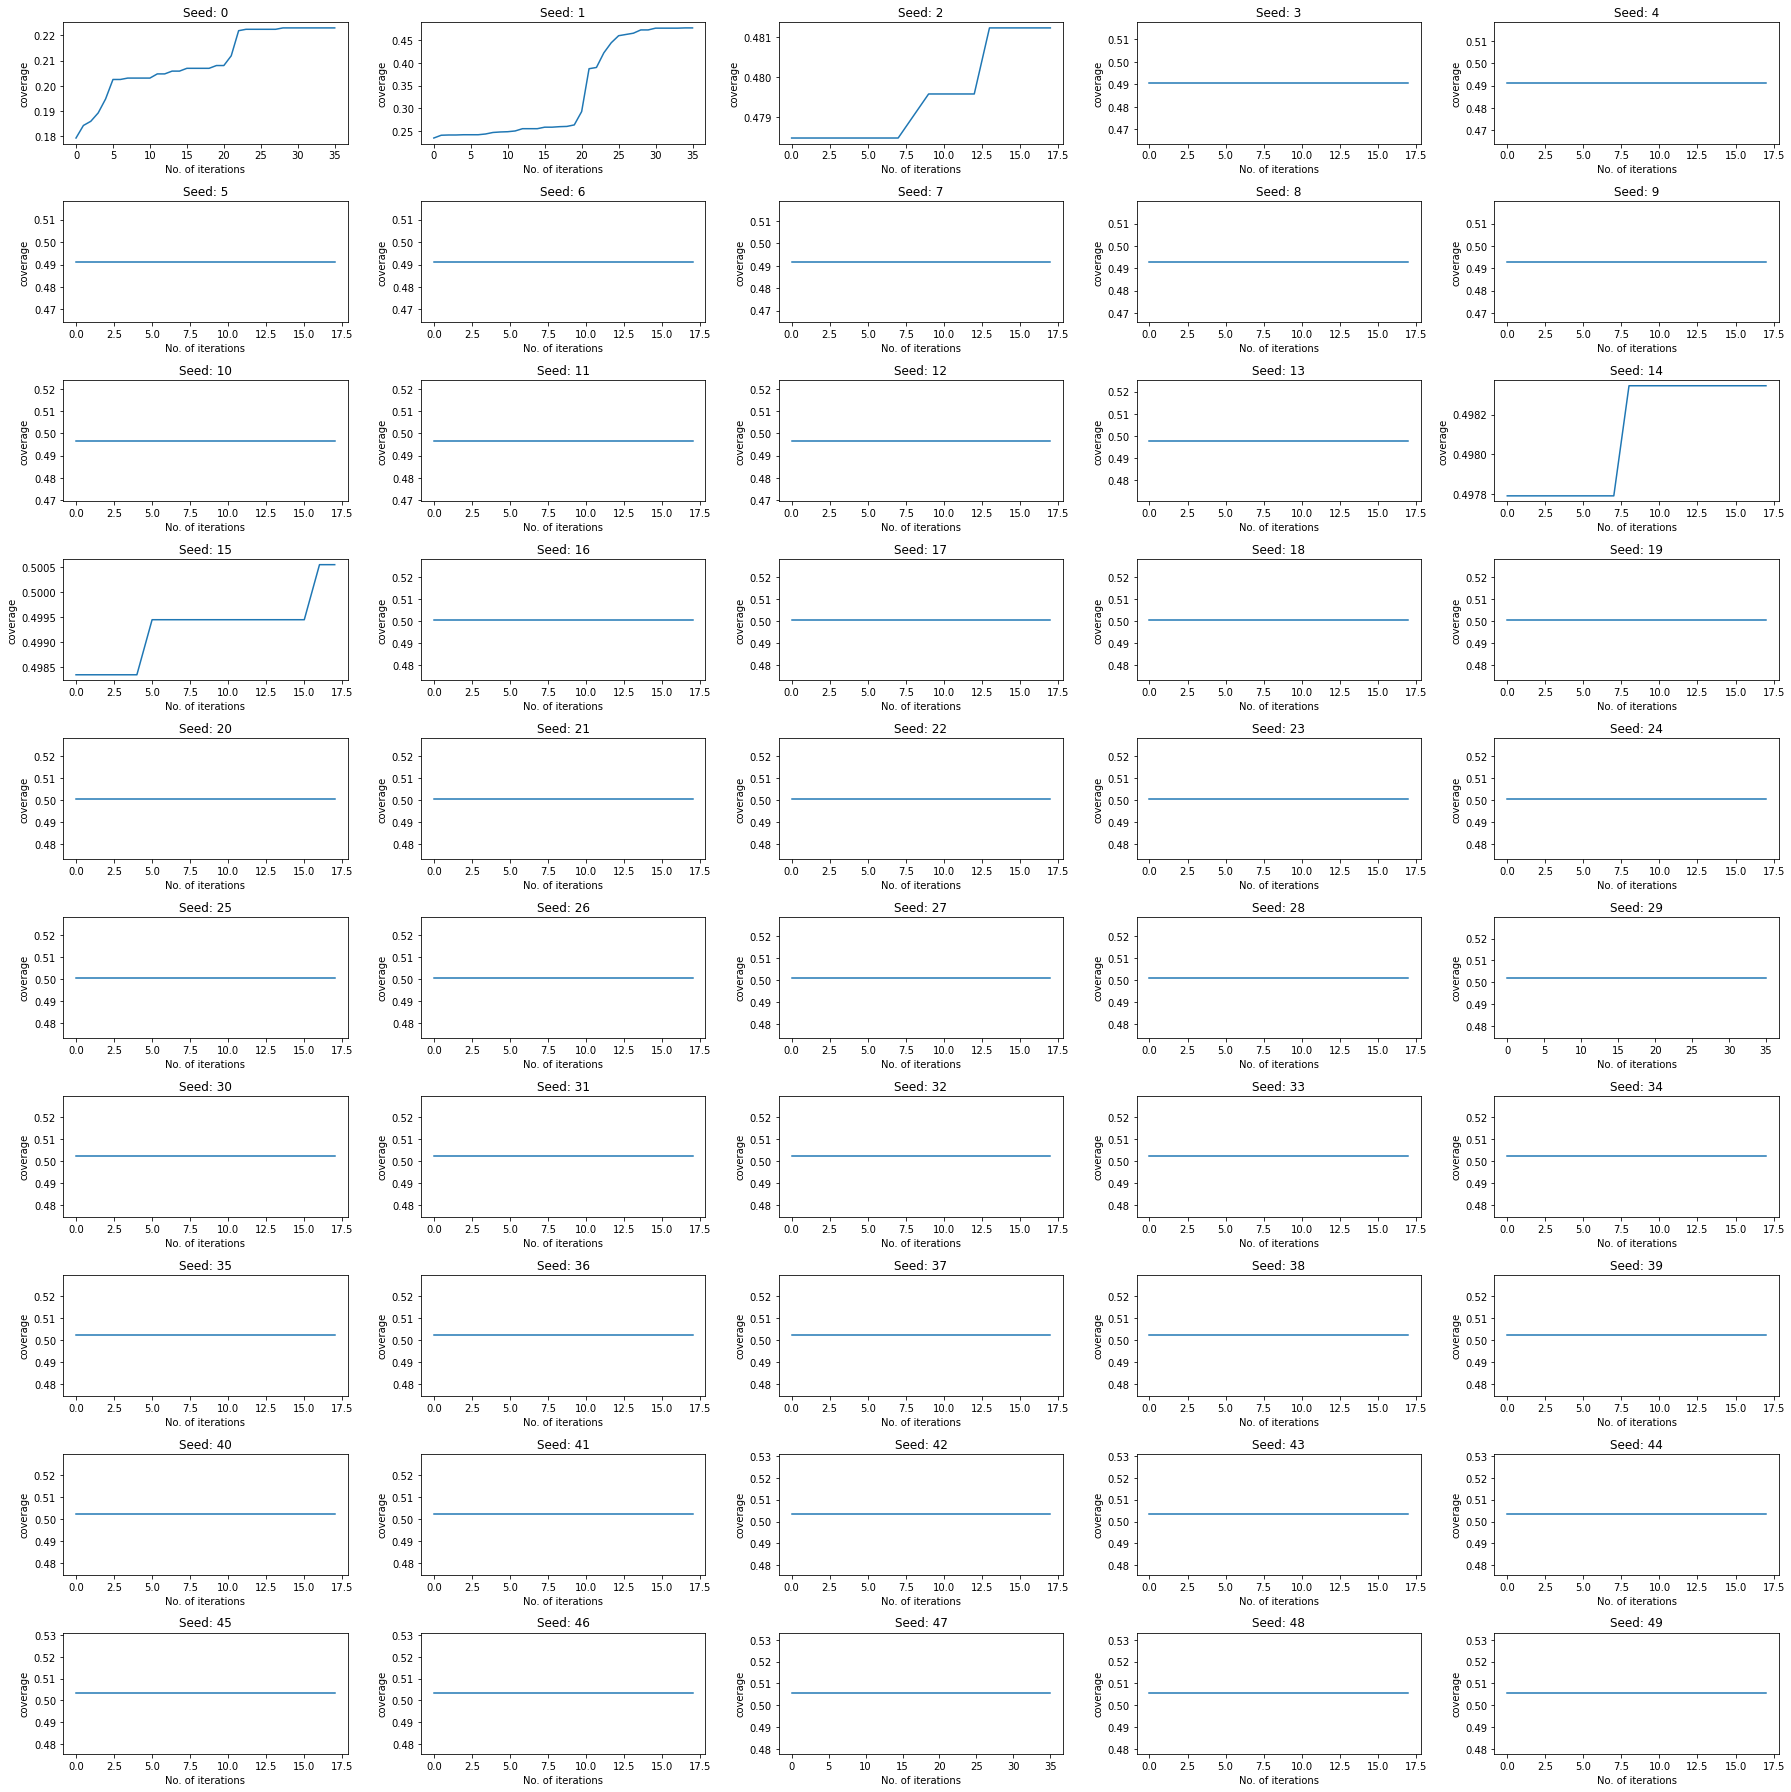

In [12]:
plt.figure(figsize=(30,10))
figure, axis = plt.subplots(10, 5, figsize = (25,25))
j=0
for i in range(50):
    axis[i//5, i%5].plot(coverage_dl[i], label = 'coverage')
    axis[i//5, i%5].set_xlabel("No. of iterations")
    axis[i//5, i%5].set_ylabel("coverage")
    axis[i//5, i%5].set_title("Seed: " + str(i))
plt.tight_layout()